In [1]:
#Handcrafted ANN

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

from sklearn import preprocessing

np.random.seed(1)
from numpy.random import RandomState
rng = RandomState(1234567890)

In [2]:
#bank note authentication data
df = pd.read_csv('data_banknote_authentication.csv', names=['variance','skewness','curtosis','entropy','class'])
X = np.array( df[['variance','skewness','curtosis','entropy']] )
Y = df['class']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.15, random_state=42)

X_train = X_train.T
X_test = X_test.T


In [3]:
#occupancy data

#load training data
df = pd.read_csv('occupancy_data/datatraining.csv')
X_train = df.drop(columns=['Occupancy']) 
X_train = preprocessing.scale(X_train).T
y_train = df['Occupancy']

#load validation data
df = pd.read_csv('occupancy_data/datatest.csv')
X_valid = df.drop(columns=['Occupancy']) 
X_valid = preprocessing.scale(X_valid).T
y_valid = df['Occupancy']


#load test data
df = pd.read_csv('occupancy_data/datatest2.csv')
X_test = df.drop(columns=['Occupancy']) 
X_test = preprocessing.scale(X_test).T
y_test = df['Occupancy']


In [4]:
df.head()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,21.7600,31.133333,437.333333,1029.666667,0.005021,1
1,21.7900,31.000000,437.333333,1000.000000,0.005009,1
2,21.7675,31.122500,434.000000,1003.750000,0.005022,1
3,21.7675,31.122500,439.000000,1009.500000,0.005022,1
4,21.7900,31.133333,437.333333,1005.666667,0.005030,1


In [5]:
#activation functions and their derivatives
def sigmoid(Z) : 
    return 1 / (1 + np.exp(-Z))

def relu(Z) : 
    return np.maximum(0, Z)

def d_sigmoid(Z) : 
    gZ = sigmoid(Z)
    return gZ * (1 - gZ)

def d_relu(Z) : 
    return np.where(Z > 0, 1, 0)

def tanh(Z) : 
    return np.tanh(Z)
    
def d_tanh(Z) : 
    return 1 - tanh(Z) ** 2
    
def activate(Z, activation) :
    if activation == 'relu' : return relu(Z)
    elif activation == 'sigmoid' : return sigmoid(Z)
    elif activation == 'tanh' : return tanh(Z)

def d_activate(Z, activation) : 
    if activation == 'relu' : return d_relu(Z)
    elif activation == 'sigmoid' : return d_sigmoid(Z)
    elif activation == 'tanh' : return d_tanh(Z)

In [6]:
#neural net
np.random.seed(1)
class neural_network :  
    
    #initialize parameters 
    def __init__(self, layers, X, Y) :
        self.layers = layers
        self.cache = {}
        self.gradients = {}
        self.parameters = {}
        self.X = X
        self.Y = np.array(Y).reshape(1, Y.shape[0])
        layers[0] = (X.shape[0], None)
        self.L = len(layers) - 1
        
        #He initialization of parameters
        for i in range(1, len(layers) ) : 
            cur_layer = layers[i][0]
            prev_layer = layers[i-1][0]
            self.parameters['W' + str(i)] = rng.randn(cur_layer, prev_layer) * np.sqrt(2 / prev_layer)
            self.parameters['b' + str(i)] = np.zeros((cur_layer, 1))
            
    
    def forward_propagation(self) :   
        Z = self.parameters['W1'].dot(self.X) + self.parameters['b1']
        A = activate(Z, layers[1][1]) 
        self.cache['Z1'] = Z
        self.cache['A1'] = A
        for i in range(2, len(self.layers)) : 
            A_prev = A
            Z = self.parameters['W' + str(i)].dot( A_prev ) + self.parameters['b' + str(i)]
            A = activate(Z, layers[i][1]) 
            self.cache['Z' + str(i)] = Z
            self.cache['A' + str(i)] = A

    
    def backward_propagation(self, lambd) :     
        dA = 0
        A = self.cache['A' + str(self.L)]
        #initialize with binary cost
        if self.layers[self.L][1] == 'sigmoid' : dA = -( np.divide(self.Y, A) - np.divide(1-self.Y, 1-A) )
        for i in reversed(range(1, self.L + 1)) :
            A_prev = np.array([])
            m = self.X.shape[1]
            if i == 1 : 
                A_prev = self.X
            else : A_prev = self.cache['A' + str(i-1)]
            #compute and store gradients 
            dZ = dA * d_activate(self.cache['Z' + str(i)], layers[i][1])
            dA = np.dot(self.parameters['W' + str(i)].T, dZ)
            
            self.gradients['dW' + str(i)] = (1/m) * dZ.dot(A_prev.T) + (lambd/m)*self.parameters['W' + str(i)]
            self.gradients['db' + str(i)] = (1/m) * np.sum(dZ, axis=1, keepdims=True)
              
    
    def update_parameters(self, alpha) :
        for i in range(1, self.L+1) : 
            self.parameters['W' + str(i)] = self.parameters['W' + str(i)] - alpha * self.gradients['dW' + str(i)]
            self.parameters['b' + str(i)] = self.parameters['b' + str(i)] - alpha * self.gradients['db' + str(i)]
    
    
    #binary cross-entropy with regularization
    def cost(self, lambd) : 
        A = self.cache['A' + str(self.L)]
        m = self.Y.shape[1]
        regSum = 0
        for i in range(1, len(self.layers) ) : 
            regSum += np.sum(np.square(self.parameters['W' + str(i)]))
        
        cost = - (1/m) * ( np.dot(self.Y, A.T) + np.dot(1 - self.Y, 1 - A.T)) + (lambd/(2*m)) * regSum
        return np.squeeze(cost)
    
    
    def train(self, alpha, iterations, lambd, show_cost = False) : 
        costs = []
        for i in range(iterations) : 
            self.forward_propagation()
            cost = self.cost(lambd)
            costs.append(cost)
            if show_cost == True and i%1000 == 0 : print(cost)
            self.backward_propagation(lambd)
            self.update_parameters(alpha)
        
        if show_cost == True : 
            plt.plot(np.arange(0,iterations), costs)
            plt.xlabel('iterations')
            plt.ylabel('cost')
            plt.show()
        
        
    def predict(self, X_test) : 
        Z = self.parameters['W1'].dot(X_test) + self.parameters['b1']
        A = activate(Z, layers[1][1])  
        for i in range(2, len(self.layers)) : 
            A_prev = A
            Z = self.parameters['W' + str(i)].dot( A_prev ) + self.parameters['b' + str(i)]
            A = activate(Z, layers[i][1]) 
        return np.where(A > .5, 1, 0) 

-0.28072561206909286
-0.8524385070218102
-0.8975366514912252
-0.9114099312476923


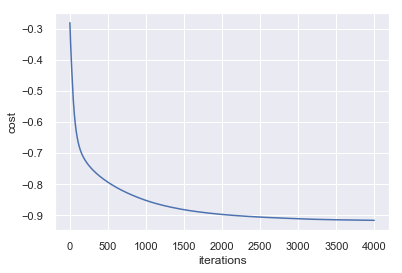

In [7]:
layers = {1: (5, 'relu'), 2: (10, 'relu'), 3: (1, 'sigmoid')}

network = neural_network(layers, X_train, y_train)
network.train(.05, 4000, 100, show_cost=True)


In [8]:
#search for lambda

lambdas = [.0001, .001, .01, .1, 1, 10, 100]
lambdas = [.05, 1, 2, 3, 4, 5]
for lambd in lambdas : 
    network = neural_network(layers, X_train, y_train)
    network.train(.05, 5000, lambd, show_cost=False)
    y_hat = network.predict(X_valid)
    y_hat = y_hat.reshape(y_valid.shape[0])
    print('validation accuracy with lambda = ', lambd, '   \t: ', accuracy_score(y_valid, y_hat))


validation accuracy with lambda =  0.05    	:  0.9470919324577861
validation accuracy with lambda =  1    	:  0.9636022514071294
validation accuracy with lambda =  2    	:  0.9377110694183864
validation accuracy with lambda =  3    	:  0.9133208255159475
validation accuracy with lambda =  4    	:  0.9279549718574108
validation accuracy with lambda =  5    	:  0.9624765478424016


In [9]:
network = neural_network(layers, X_train, y_train)
network.train(.05, 5000, 1, show_cost=False)


y_hat = network.predict(X_test)
y_hat = y_hat.reshape(y_test.shape[0])
print('test accuracy: ', accuracy_score(y_test, y_hat))
    
print('confusion matrix: \n', confusion_matrix(y_test, y_hat))


test accuracy:  0.9875922887612797
confusion matrix: 
 [[7667   36]
 [  85 1964]]
